In [19]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Load partitioned Parquet dataset into a Dask DataFrame
ddf = dd.read_parquet('finalData.parquet', engine='pyarrow')

# Optionally convert to pandas DataFrame
ZTBus = ddf.compute()
print(type(ZTBus))

<class 'pandas.core.frame.DataFrame'>


In [21]:
print(ZTBus.dtypes)

electric_powerDemand                       float32
gnss_altitude                              float32
gnss_latitude                              float32
gnss_longitude                             float32
status_doorIsOpen                          float32
status_gridIsAvailable                     float32
temperature_ambient                        float32
traction_brakePressure                     float32
traction_tractionForce                     float32
busNumber                                    uint8
busRoute                                  category
timestamp                           datetime64[ns]
location_cluster                             uint8
wheelSpeed_mean                            float32
wheelSpeed_left_right_diff                 float32
brake_status                                 uint8
itcs_numberOfPassengers_central            float32
itcs_numberOfPassengers_range                uint8
itcs_numberOfPassengers_spread             float32
is_stationary                  

--- Start of the core modelling and in-depth analysis ---

---------------

-------------

-----------------

In [22]:
class RouteBehavioralProfiler:
    """
    Bus Route Behavioral Profiling using K-Means clustering
    Identifies operational patterns and route personalities
    """
    
    def __init__(self, n_clusters=None, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = None
        self.scaler = StandardScaler()
        self.behavioral_features = None
        self.route_profiles = None
        
    def create_behavioral_features(self, df):
        """
        Create route-level behavioral features from raw bus data
        
        Parameters:
        df: DataFrame with columns as specified in your data description
        """
        print("Creating behavioral features for routes...")
        
        # Group by busRoute and create behavioral profiles
        route_behaviors = []
        
        for route in df['busRoute'].unique():
            if pd.isna(route):  # Skip NaN routes
                continue
                
            route_data = df[df['busRoute'] == route]
            
            # Speed and Movement Behavior
            speed_profile = {
                'avg_speed': route_data['wheelSpeed_mean'].mean(),
                'speed_variability': route_data['wheelSpeed_mean'].std(),
                'max_speed': route_data['wheelSpeed_mean'].max(),
                'speed_acceleration_events': (route_data['wheelSpeed_mean'].diff() > 2).sum(),
                'stationary_frequency': route_data['is_stationary'].mean(),
            }
            
            # Braking and Traction Behavior
            braking_profile = {
                'avg_brake_pressure': route_data['traction_brakePressure'].mean(),
                'brake_intensity': route_data['traction_brakePressure'].std(),
                'heavy_braking_events': (route_data['traction_brakePressure'] > route_data['traction_brakePressure'].quantile(0.9)).sum(),
                'avg_traction_force': route_data['traction_tractionForce'].mean(),
                'traction_variability': route_data['traction_tractionForce'].std(),
                'brake_status_changes': route_data['brake_status'].diff().abs().sum(),
            }
            
            # Power and Efficiency Behavior
            power_profile = {
                'avg_power_demand': route_data['electric_powerDemand'].mean(),
                'power_efficiency': route_data['electric_powerDemand'].std(),
                'regenerative_braking_freq': (route_data['electric_powerDemand'] < 0).mean(),
                'peak_power_events': (route_data['electric_powerDemand'] > route_data['electric_powerDemand'].quantile(0.95)).sum(),
            }
            
            # Passenger Service Behavior
            passenger_profile = {
                'avg_passenger_load': route_data['itcs_numberOfPassengers_central'].mean(),
                'passenger_variability': route_data['itcs_numberOfPassengers_spread'].mean(),
                'passenger_range': route_data['itcs_numberOfPassengers_range'].mean(),
                'door_opening_frequency': route_data['status_doorIsOpen'].mean(),
                'peak_passenger_load': route_data['itcs_numberOfPassengers_central'].max(),
            }
            
            # Environmental and Route Characteristics
            environmental_profile = {
                'temperature_exposure': route_data['temperature_ambient'].mean(),
                'temperature_variability': route_data['temperature_ambient'].std(),
                'altitude_variation': route_data['gnss_altitude'].std(),
                'avg_altitude': route_data['gnss_altitude'].mean(),
                'grid_availability': route_data['status_gridIsAvailable'].mean(),
            }
            
            # Directional Stability and Course Behavior
            course_profile = {
                'course_stability': 1 - route_data['gnss_course_stationary_var'].mean(),
                'directional_changes': route_data['gnss_course_stationary_zero_flag'].sum(),
                'route_consistency': 1 - route_data[['gnss_latitude', 'gnss_longitude']].std().mean(),
            }
            
            # Combine all profiles
            route_behavior = {
                'busRoute': route,
                'total_records': len(route_data),
                **speed_profile,
                **braking_profile,
                **power_profile,
                **passenger_profile,
                **environmental_profile,
                **course_profile
            }
            
            route_behaviors.append(route_behavior)
        
        self.behavioral_features = pd.DataFrame(route_behaviors)
        print(f"Created behavioral profiles for {len(self.behavioral_features)} routes")
        return self.behavioral_features
    
    def determine_optimal_clusters(self, df=None, max_clusters=15):
        """
        Use elbow method and silhouette analysis to find optimal number of clusters
        
        Parameters:
        df: DataFrame - Raw bus data (optional, will use existing behavioral_features if None)
        max_clusters: int - Maximum number of clusters to test
        """
        # Create behavioral features if df provided or if not already created
        if df is not None:
            self.create_behavioral_features(df)
        elif self.behavioral_features is None:
            raise ValueError("Please provide dataframe or create behavioral features first")
        
        # Prepare features for clustering (exclude non-numeric columns)
        feature_cols = [col for col in self.behavioral_features.columns 
                       if col not in ['busRoute', 'total_records']]
        X = self.behavioral_features[feature_cols].fillna(0)
        X_scaled = self.scaler.fit_transform(X)
        
        # Validate sample size and adjust max_clusters
        n_samples = len(X_scaled)
        if n_samples < 2:
            raise ValueError(f"Need at least 2 routes for clustering, got {n_samples}")
        
        # Adjust max_clusters based on available samples
        max_possible_clusters = min(max_clusters, n_samples - 1)
        if max_possible_clusters < 2:
            max_possible_clusters = 2
            
        print(f"Testing {n_samples} routes with up to {max_possible_clusters} clusters")
        
        # Ensure we don't test more clusters than we have samples
        if max_clusters > max_possible_clusters:
            print(f"Note: Reduced max_clusters from {max_clusters} to {max_possible_clusters} based on sample size")
        
        # Calculate metrics for different cluster numbers
        inertias = []
        silhouette_scores = []
        k_range = range(2, max_possible_clusters + 1)
        
        print(f"Testing cluster range: {list(k_range)}")
        
        for k in k_range:
            try:
                kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
                cluster_labels = kmeans.fit_predict(X_scaled)
                
                inertias.append(kmeans.inertia_)
                
                # Only calculate silhouette score if we have enough unique labels
                n_unique_labels = len(np.unique(cluster_labels))
                if n_unique_labels >= 2 and n_unique_labels < n_samples:
                    sil_score = silhouette_score(X_scaled, cluster_labels)
                    silhouette_scores.append(sil_score)
                else:
                    silhouette_scores.append(-1)  # Invalid score
                    print(f"Warning: Cluster k={k} produced only {n_unique_labels} unique labels")
                    
            except Exception as e:
                print(f"Error with k={k}: {str(e)}")
                inertias.append(np.nan)
                silhouette_scores.append(-1)
        
        # Filter out invalid silhouette scores
        valid_silhouette_scores = [(i, score) for i, score in enumerate(silhouette_scores) if score > -1]
        
        if not valid_silhouette_scores:
            print("Warning: No valid silhouette scores found. Using elbow method only.")
            optimal_k = k_range[np.argmin(np.diff(inertias))] if len(inertias) > 1 else k_range[0]
        else:
            # Find optimal k from valid silhouette scores
            best_idx, best_score = max(valid_silhouette_scores, key=lambda x: x[1])
            optimal_k = k_range[best_idx]
        
        # Plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Elbow curve
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal Clusters')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette scores (only plot valid ones)
        if valid_silhouette_scores:
            valid_k_values = [k_range[i] for i, _ in valid_silhouette_scores]
            valid_scores = [score for _, score in valid_silhouette_scores]
            ax2.plot(valid_k_values, valid_scores, 'ro-')
            ax2.set_xlabel('Number of Clusters')
            ax2.set_ylabel('Silhouette Score')
            ax2.set_title('Silhouette Score vs Number of Clusters')
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No valid silhouette scores\n(not enough samples)', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Silhouette Analysis (Insufficient Data)')
        
        # Suggest optimal number of clusters
        if valid_silhouette_scores:
            best_score = max(score for _, score in valid_silhouette_scores)
            print(f"Suggested optimal number of clusters: {optimal_k} (silhouette score: {best_score:.3f})")
        else:
            print(f"Suggested optimal number of clusters: {optimal_k} (based on elbow method)")
        
        plt.tight_layout()

        plt.savefig("kMeansInertiaVSSilScore.jpg", dpi=300, bbox_inches="tight")
        plt.show()
        
        return optimal_k, silhouette_scores, inertias

    # Needs to be updated
    # def plot_clusters_2D(X_scaled, kmeans_model, method="pca", random_state=42, save_path=None):
        """
        Visualize clusters in 2D using PCA or t-SNE.
    
        Parameters:
        X_scaled : array-like
            Scaled feature matrix used for clustering.
        kmeans_model : fitted KMeans object
            Trained KMeans model with cluster labels and centers.
        method : str, optional (default="pca")
            Dimensionality reduction method: "pca" or "tsne".
        random_state : int, optional (default=42)
            Random seed for reproducibility.
        save_path : str, optional
            If provided, saves the figure to this path.
        """
        """
        labels = kmeans_model.labels_
    
        # Dimensionality reduction
        if method.lower() == "pca":
            reducer = PCA(n_components=2, random_state=random_state)
            X_2d = reducer.fit_transform(X_scaled)
            centers_2d = reducer.transform(kmeans_model.cluster_centers_)
        elif method.lower() == "tsne":
            reducer = TSNE(n_components=2, random_state=random_state, perplexity=30, n_iter=1000)
            X_2d = reducer.fit_transform(X_scaled)
            centers_2d = None  # t-SNE doesn't allow direct transformation of centroids
        else:
            raise ValueError("method must be 'pca' or 'tsne'")
    
        # Plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="tab10", alpha=0.7)
    
        # Plot centroids (only if PCA was used)
        if centers_2d is not None:
            plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
                        c="black", s=200, marker="X", label="Centroids")
    
        plt.title(f"Clusters Visualized in 2D ({method.upper()})")
        plt.xlabel(f"{method.upper()} Component 1")
        plt.ylabel(f"{method.upper()} Component 2")
        plt.legend(*scatter.legend_elements(), title="Clusters", loc="best")
        plt.grid(alpha=0.3)
        plt.tight_layout()
    
        # Save or show
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()
        """
    
    def fit_behavioral_clusters(self, df=None, n_clusters=None):
        """
        Fit K-means clustering on behavioral features
        
        Parameters:
        df: DataFrame - Raw bus data (optional, will use existing behavioral_features if None)
        n_clusters: int - Number of clusters (optional, will determine optimal if None)
        """
        # Create behavioral features if df provided or if not already created
        if df is not None:
            self.create_behavioral_features(df)
        elif self.behavioral_features is None:
            raise ValueError("Please provide dataframe or create behavioral features first")
            
        if n_clusters:
            self.n_clusters = n_clusters
        elif self.n_clusters is None:
            self.n_clusters, _, _ = self.determine_optimal_clusters()
        
        # Prepare features
        feature_cols = [col for col in self.behavioral_features.columns 
                       if col not in ['busRoute', 'total_records']]
        X = self.behavioral_features[feature_cols].fillna(0)
        X_scaled = self.scaler.fit_transform(X)
        
        # Fit K-means
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        cluster_labels = self.kmeans.fit_predict(X_scaled)
        
        # Add cluster labels to behavioral features
        self.behavioral_features['cluster'] = cluster_labels
        
        print(f"Successfully clustered {len(self.behavioral_features)} routes into {self.n_clusters} behavioral segments")
        return cluster_labels
    
    def analyze_cluster_characteristics(self):
        """
        Analyze and interpret the behavioral characteristics of each cluster
        """
        if 'cluster' not in self.behavioral_features.columns:
            raise ValueError("Please fit clusters first")
        
        cluster_summary = {}
        feature_cols = [col for col in self.behavioral_features.columns 
                       if col not in ['busRoute', 'total_records', 'cluster']]
        
        for cluster_id in sorted(self.behavioral_features['cluster'].unique()):
            cluster_data = self.behavioral_features[self.behavioral_features['cluster'] == cluster_id]
            
            # Calculate mean values for this cluster
            cluster_means = cluster_data[feature_cols].mean()
            
            # Identify top characteristics (features with highest values relative to overall mean)
            overall_means = self.behavioral_features[feature_cols].mean()
            relative_strength = (cluster_means / overall_means).sort_values(ascending=False)
            
            cluster_summary[cluster_id] = {
                'route_count': len(cluster_data),
                'routes': cluster_data['busRoute'].tolist(),
                'top_characteristics': relative_strength.head(5).to_dict(),
                'mean_values': cluster_means.to_dict()
            }
            
        self.route_profiles = cluster_summary
        return cluster_summary
    
    def visualize_behavioral_profiles(self):
        """
        Create visualizations of the behavioral clusters
        """
        if self.route_profiles is None:
            self.analyze_cluster_characteristics()
        
        # Select key behavioral features for visualization
        key_features = [
            'avg_speed', 'avg_brake_pressure', 'avg_power_demand', 
            'avg_passenger_load', 'stationary_frequency', 'door_opening_frequency'
        ]
        
        # Create cluster comparison plot
        cluster_means = []
        for cluster_id, profile in self.route_profiles.items():
            cluster_mean = {**{'cluster': f'Cluster {cluster_id}'}, 
                          **{feat: profile['mean_values'][feat] for feat in key_features}}
            cluster_means.append(cluster_mean)
        
        cluster_df = pd.DataFrame(cluster_means)
        
        # Normalize features for better visualization
        for feat in key_features:
            cluster_df[f'{feat}_norm'] = (cluster_df[feat] - cluster_df[feat].min()) / (cluster_df[feat].max() - cluster_df[feat].min())
        
        # Create radar chart
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Cluster size distribution
        cluster_sizes = [profile['route_count'] for profile in self.route_profiles.values()]
        axes[0,0].pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(len(cluster_sizes))], 
                     autopct='%1.1f%%', startangle=90)
        axes[0,0].set_title('Route Distribution Across Clusters')
        
        # Feature comparison heatmap
        heatmap_data = cluster_df.set_index('cluster')[[f'{feat}_norm' for feat in key_features]]
        heatmap_data.columns = key_features
        sns.heatmap(heatmap_data, annot=True, cmap='RdYlBu_r', ax=axes[0,1], 
                   cbar_kws={'label': 'Normalized Feature Value'})
        axes[0,1].set_title('Behavioral Profile Comparison')
        
        # Speed vs Power efficiency scatter
        axes[1,0].scatter(self.behavioral_features['avg_speed'], 
                         self.behavioral_features['avg_power_demand'],
                         c=self.behavioral_features['cluster'], 
                         cmap='viridis', alpha=0.7)
        axes[1,0].set_xlabel('Average Speed')
        axes[1,0].set_ylabel('Average Power Demand')
        axes[1,0].set_title('Speed vs Power Demand by Cluster')
        
        # Passenger load vs Door opening frequency
        axes[1,1].scatter(self.behavioral_features['avg_passenger_load'], 
                         self.behavioral_features['door_opening_frequency'],
                         c=self.behavioral_features['cluster'], 
                         cmap='viridis', alpha=0.7)
        axes[1,1].set_xlabel('Average Passenger Load')
        axes[1,1].set_ylabel('Door Opening Frequency')
        axes[1,1].set_title('Passenger Load vs Service Frequency by Cluster')
        
        plt.tight_layout()

        plt.savefig("clusterDataPoints.jpg", dpi=600, bbox_inches="tight")
        plt.show()
    
    def interpret_clusters(self):
        """
        Provide business interpretations of the behavioral clusters
        """
        if self.route_profiles is None:
            self.analyze_cluster_characteristics()
        
        interpretations = {}
        
        for cluster_id, profile in self.route_profiles.items():
            top_chars = profile['top_characteristics']
            route_count = profile['route_count']
            routes = profile['routes']
            
            # Generate interpretation based on top characteristics
            interpretation = f"Cluster {cluster_id} ({route_count} routes):\n"
            interpretation += f"Routes: {', '.join(map(str, routes))}\n"
            
            # Analyze behavioral pattern
            if top_chars.get('avg_speed', 0) > 1.2:
                interpretation += "- HIGH-SPEED routes (highway/express routes)\n"
            elif top_chars.get('stationary_frequency', 0) > 1.2:
                interpretation += "- STOP-AND-GO routes (urban/local routes)\n"
            
            if top_chars.get('avg_passenger_load', 0) > 1.3:
                interpretation += "- HIGH-CAPACITY routes (major transit corridors)\n"
            elif top_chars.get('door_opening_frequency', 0) > 1.3:
                interpretation += "- HIGH-FREQUENCY SERVICE routes (many stops)\n"
            
            if top_chars.get('avg_brake_pressure', 0) > 1.2:
                interpretation += "- INTENSIVE BRAKING routes (hilly/congested areas)\n"
                
            if top_chars.get('avg_power_demand', 0) > 1.2:
                interpretation += "- POWER-INTENSIVE routes (challenging terrain/heavy loads)\n"
            elif top_chars.get('regenerative_braking_freq', 0) > 1.2:
                interpretation += "- ENERGY-EFFICIENT routes (good regenerative braking)\n"
            
            interpretations[cluster_id] = interpretation
        
        # Print all interpretations
        print("=== ROUTE BEHAVIORAL CLUSTER INTERPRETATIONS ===\n")
        for cluster_id, interpretation in interpretations.items():
            print(interpretation)
            print("-" * 60)
        
        return interpretations

    def full_pipeline(self, df, n_clusters=None, max_clusters=15, visualize=True):
        """
        Complete end-to-end behavioral clustering pipeline
        
        Parameters:
        df: DataFrame - Raw bus data with required columns
        n_clusters: int - Number of clusters (if None, will determine optimal)
        max_clusters: int - Maximum clusters to test for optimization
        visualize: bool - Whether to create visualizations
        
        Returns:
        dict: Complete analysis results including clusters, profiles, and recommendations
        """
        print("=== STARTING ROUTE BEHAVIORAL CLUSTERING PIPELINE ===\n")
        
        # Step 1: Create behavioral features
        print("Step 1: Creating behavioral features...")
        behavioral_features = self.create_behavioral_features(df)
        print(f"✓ Created {len(behavioral_features)} route behavioral profiles\n")
        
        # Step 2: Determine optimal clusters (if not specified)
        if n_clusters is None:
            print("Step 2: Determining optimal number of clusters...")
            optimal_k, silhouette_scores, inertias = self.determine_optimal_clusters(max_clusters=max_clusters)
            n_clusters = optimal_k
            print(f"✓ Optimal clusters determined: {optimal_k}\n")
        else:
            print(f"Step 2: Using specified number of clusters: {n_clusters}\n")
        
        # Step 3: Fit clustering model
        print("Step 3: Fitting K-means clustering...")
        cluster_labels = self.fit_behavioral_clusters(n_clusters=n_clusters)
        print(f"✓ Successfully clustered routes into {n_clusters} segments\n")
        
        # Step 4: Analyze clusters
        print("Step 4: Analyzing cluster characteristics...")
        cluster_summary = self.analyze_cluster_characteristics()
        print("✓ Cluster analysis complete\n")
        
        # Step 5: Generate business interpretations
        print("Step 5: Generating business interpretations...")
        interpretations = self.interpret_clusters()
        print("✓ Business interpretations generated\n")

        
        # Step 6: Print route assignments
        # print("Step 6: Printing route assignments...")
        # route_assignments = self.print_route_assignments()
        # print("✓ Route assignments displayed\n")
        
        # Step 6: Create visualizations
        if visualize:
            print("Step 6: Creating visualizations...")
            self.visualize_behavioral_profiles()
            print("✓ Visualizations complete\n")
        
        # Compile complete results
        results = {
            'behavioral_features': self.behavioral_features,
            'cluster_labels': cluster_labels,
            'cluster_profiles': self.route_profiles,
            'interpretations': interpretations,
            'model_metrics': {
                'n_clusters': self.n_clusters,
                'total_routes': len(behavioral_features),
                'silhouette_score': silhouette_score(
                    self.scaler.transform(behavioral_features[[col for col in behavioral_features.columns 
                                                              if col not in ['busRoute', 'total_records', 'cluster']]].fillna(0)),
                    cluster_labels
                ) if hasattr(self, 'scaler') else None
            },
            'route_assignments': dict(zip(behavioral_features['busRoute'], cluster_labels)),
            'route_assignments_detailed': self.print_route_assignments() if hasattr(self, 'behavioral_features') and 'cluster' in self.behavioral_features.columns else None
        }
        
        print("=== PIPELINE COMPLETE ===")
        print(f"Successfully analyzed {len(behavioral_features)} routes across {self.n_clusters} behavioral clusters")
        
        return results

In [23]:
    """
    Example of how to use the RouteBehavioralProfiler
    """
    
    # Initialize the profiler
    # profiler = RouteBehavioralProfiler()
    
    # Load your data (replace with actual data loading)
    # df = pd.read_csv('your_bus_data.csv')
    
    # Step 1: Create behavioral features from raw data
    # behavioral_features = profiler.create_behavioral_features(df)
    
    # Step 2: Determine optimal number of clusters
    # optimal_k, silhouette_scores, inertias = profiler.determine_optimal_clusters()
    
    # Step 3: Fit the clustering model
    # cluster_labels = profiler.fit_behavioral_clusters(n_clusters=optimal_k)
    
    # Step 4: Analyze cluster characteristics
    # cluster_summary = profiler.analyze_cluster_characteristics()
    
    # Step 5: Visualize the results
    # profiler.visualize_behavioral_profiles()
    
    # Step 6: Get business interpretations
    # interpretations = profiler.interpret_clusters()
    
    #print("Route Behavioral Profiling Pipeline Ready!")
    #print("Load your data and uncomment the steps to run the analysis.")

'\nExample of how to use the RouteBehavioralProfiler\n'

In [24]:
profiler = RouteBehavioralProfiler()

In [25]:
behavioral_features = profiler.create_behavioral_features(ZTBus)

Creating behavioral features for routes...
Created behavioral profiles for 9 routes


Testing 9 routes with up to 8 clusters
Note: Reduced max_clusters from 15 to 8 based on sample size
Testing cluster range: [2, 3, 4, 5, 6, 7, 8]
Suggested optimal number of clusters: 5 (silhouette score: 0.276)


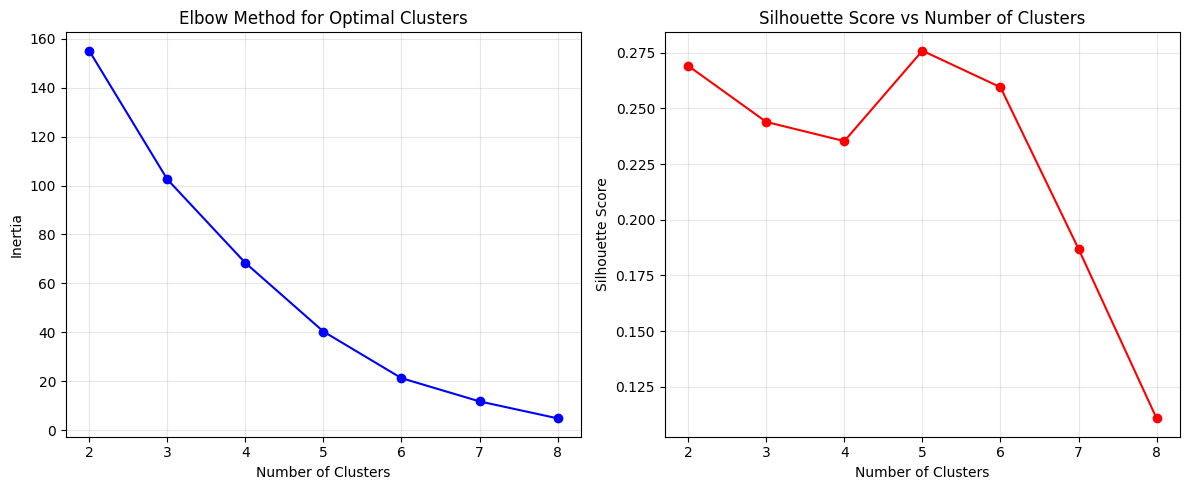

In [26]:
optimal_k, silhouette_scores, inertias = profiler.determine_optimal_clusters()

In [27]:
cluster_labels = profiler.fit_behavioral_clusters(n_clusters=optimal_k)

Successfully clustered 9 routes into 5 behavioral segments


In [28]:
cluster_summary = profiler.analyze_cluster_characteristics()

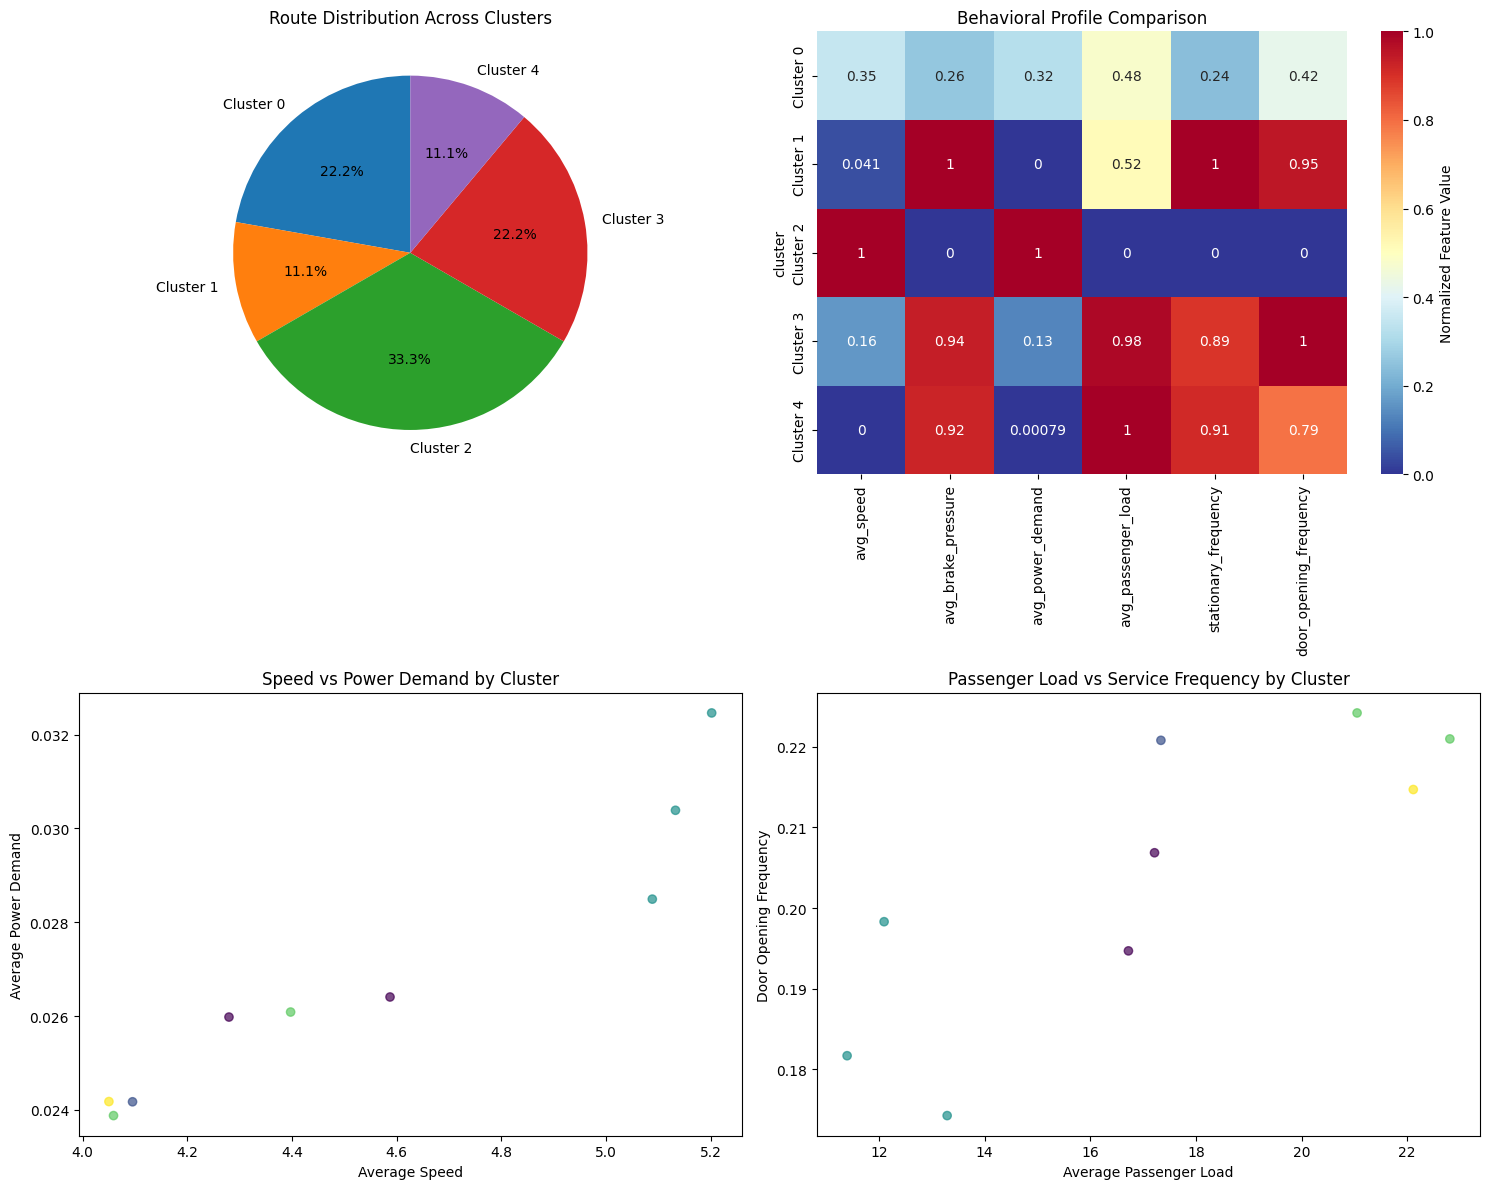

In [29]:
profiler.visualize_behavioral_profiles()

In [30]:
interpretations = profiler.interpret_clusters()

=== ROUTE BEHAVIORAL CLUSTER INTERPRETATIONS ===

Cluster 0 (2 routes):
Routes: 33, 46

------------------------------------------------------------
Cluster 1 (1 routes):
Routes: 83

------------------------------------------------------------
Cluster 2 (3 routes):
Routes: N4, N2, N1

------------------------------------------------------------
Cluster 3 (2 routes):
Routes: 72, 32

------------------------------------------------------------
Cluster 4 (1 routes):
Routes: 31

------------------------------------------------------------


In [16]:
#results = profiler.full_pipeline(ZTBus)